In [574]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import math

from numpy import genfromtxt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from itertools import permutations

In [543]:
data_path = "data"
images = [np.array(Image.open(os.path.join(data_path, f"{i+1}.png"))) for i in range(1000)]
outputs = [genfromtxt(os.path.join(data_path, f"{i+1}.txt"), delimiter=' ') for i in range(1000)]

In [434]:
def plot_images(n, images, figsize=(12, 8), cmap='gray'):
    cols = math.ceil(math.sqrt(n))
    rows = int(math.sqrt(n))
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.ravel() if isinstance(axes, np.ndarray) else [axes]
    
    for idx, ax in enumerate(axes):
        if idx < n:
            ax.imshow(images[idx], cmap=cmap)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

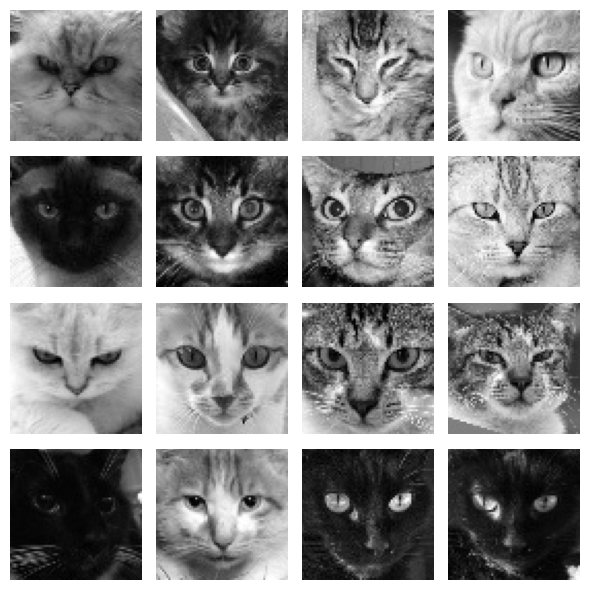

(64, 64)

In [544]:
plot_images(16, images, figsize=(6, 6))
images[0].shape

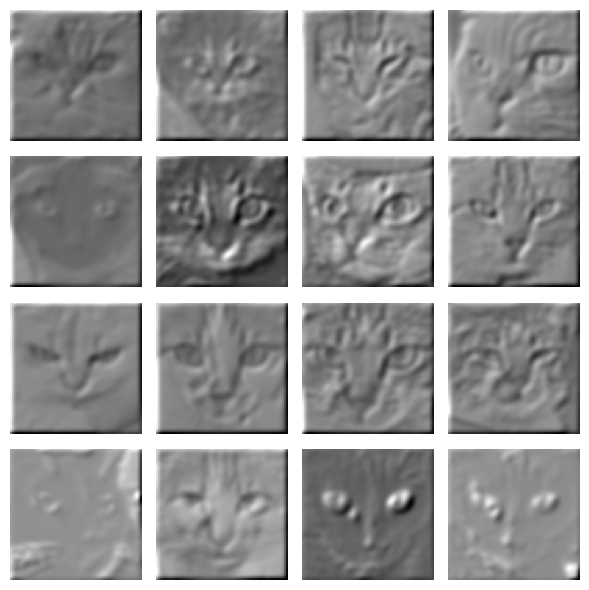

(64, 64)

In [545]:
plot_images(16, outputs, figsize=(6, 6))
outputs[0].shape

In [573]:
filters = genfromtxt(os.path.join(data_path, "algos.csv"), delimiter=',').reshape(2, 3, 3)
filters

array([[[-1.    , -0.5   ,  0.    ],
        [-0.5   ,  0.5   ,  0.5   ],
        [ 0.    ,  0.5   ,  1.    ]],

       [[ 0.0625,  0.0625,  0.0625],
        [ 0.0625,  0.0625,  0.0625],
        [ 0.0625,  0.0625,  0.0625]]])

In [438]:
transform_to_tensor = transforms.Compose([
        transforms.ToTensor(),
    ])

In [439]:
def load_params_to_conv(layer, filter):
    if filter is not None:
        layer.weight = nn.Parameter(torch.tensor(filter.reshape(1, 1, 3, 3), dtype=torch.float32), requires_grad=False)
    layer.bias = nn.Parameter(torch.tensor([0], dtype=torch.float32), requires_grad=False)

In [557]:
from torch.utils.data import Dataset
class MyDataset(Dataset):
    def __init__(self, transform=None):
        data_path = "data"
        self.images = [np.array(Image.open(os.path.join(data_path, f"{i + 1}.png"))) for i in range(1000)]
        self.transformed_images = [genfromtxt(os.path.join(data_path, f"{i + 1}.txt"), delimiter=' ') for i in range(1000)]
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.transformed_images[idx]
        if self.transform:
            image = self.transform(image) * 255
            label = self.transform(label)
        return image, label.float()

In [558]:
dataset = MyDataset(transform=transform_to_tensor)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [572]:
all_permutations = list(permutations([0, 1, 2]))
epoch = 10

best_loss = np.inf
best_combination = []

for permutation in all_permutations:
    layers = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1),
    nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1),
    nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1)
    )
    load_params_to_conv(layers[permutation[0]], filters[0])
    load_params_to_conv(layers[permutation[1]], filters[1])
    load_params_to_conv(layers[permutation[2]], None)

    optimizer = torch.optim.Adam(layers.parameters(), lr=1)
    criterion = nn.MSELoss()
    
    last_loss = 0
    for i in range(epoch):
        epoch_loss = []
        for images_, labels in dataloader:
            optimizer.zero_grad()
            transformed_images = layers(images_)
    
            loss = criterion(transformed_images, labels.float())
            epoch_loss.append(loss.item())
            loss.backward()
            optimizer.step()
            
        last_loss = sum(epoch_loss) / len(epoch_loss)

    print(f"Combination: {permutation}  Loss: {last_loss}")
    if last_loss < best_loss:
        best_loss = last_loss
        best_combination = permutation
        
print(f"Best combination: {best_combination}  Best loss: {best_loss}")

Combination: (0, 1, 2)  Loss: 905.2148246765137
Combination: (0, 2, 1)  Loss: 925.8377285003662
Combination: (1, 0, 2)  Loss: 44.550179839134216
Combination: (1, 2, 0)  Loss: 517.5374727249146
Combination: (2, 0, 1)  Loss: 0.03583371907006949
Combination: (2, 1, 0)  Loss: 0.2984661217778921
Best combination: (2, 0, 1)  Best loss: 0.03583371907006949


In [569]:
layers = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1),
    nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1),
    nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1)
)
load_params_to_conv(layers[2], filters[0])
load_params_to_conv(layers[0], filters[1])
load_params_to_conv(layers[1], None)

epoch = 1000
optimizer = torch.optim.Adam(layers.parameters(), lr=0.001)
criterion = nn.MSELoss()

for i in range(epoch):
    epoch_loss = []
    for images_, labels in dataloader:
        optimizer.zero_grad()
        transformed_images = layers(images_)

        loss = criterion(transformed_images, labels)
        epoch_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        
    print(f"Epoch: {i+1}    Loss: {sum(epoch_loss)/len(epoch_loss)}")
        

Epoch: 1    Loss: 5408.746925354004
Epoch: 2    Loss: 3730.4835510253906
Epoch: 3    Loss: 2440.5221519470215
Epoch: 4    Loss: 1538.733570098877
Epoch: 5    Loss: 940.7048587799072
Epoch: 6    Loss: 555.7771692276001
Epoch: 7    Loss: 322.3347969055176
Epoch: 8    Loss: 190.43926620483398
Epoch: 9    Loss: 116.05210161209106
Epoch: 10    Loss: 76.47575616836548
Epoch: 11    Loss: 57.08433532714844
Epoch: 12    Loss: 46.84753334522247
Epoch: 13    Loss: 41.18655061721802
Epoch: 14    Loss: 37.42664873600006
Epoch: 15    Loss: 34.72008800506592
Epoch: 16    Loss: 32.253979086875916
Epoch: 17    Loss: 30.01466989517212
Epoch: 18    Loss: 28.014103293418884
Epoch: 19    Loss: 26.188170433044434
Epoch: 20    Loss: 24.188665986061096
Epoch: 21    Loss: 22.405250251293182
Epoch: 22    Loss: 20.731017231941223
Epoch: 23    Loss: 19.176587104797363
Epoch: 24    Loss: 17.57128405570984
Epoch: 25    Loss: 16.156506717205048
Epoch: 26    Loss: 14.770219594240189
Epoch: 27    Loss: 13.724524170160

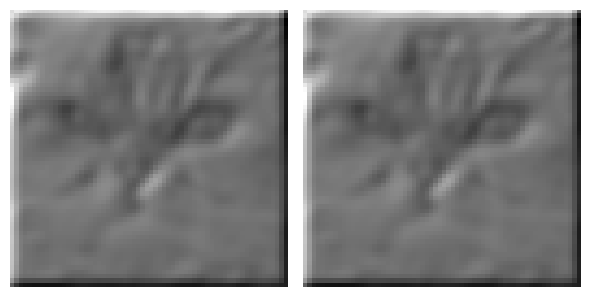

MSE: 1.971572410147572e-10


In [570]:
layers.eval()
transformed_image = layers(transform_to_tensor(images[0]) * 255).detach().numpy().reshape(64, 64)
plot_images(2, [transformed_image, outputs[0]], figsize=(6, 6), cmap='gray')

total_mse = 0
for image, output in zip(images, outputs):
    transformed_image = layers(transform_to_tensor(image) * 255).detach().numpy().reshape(64, 64)
    # print(np.max(image), np.max(transformed_image), np.max(outputs))
    total_mse += np.square(output - transformed_image).mean()
total_mse = total_mse / len(images)
print("MSE:", total_mse)

In [571]:
ans_filters = np.stack([layers[i].weight.detach().numpy().reshape(9) for i in range(3)], axis=0)
np.savetxt("reconstructed_algos.csv", ans_filters, delimiter=",")
ans_filters

array([[ 0.0625    ,  0.0625    ,  0.0625    ,  0.0625    ,  0.0625    ,
         0.0625    ,  0.0625    ,  0.0625    ,  0.0625    ],
       [ 0.12500016,  0.25000003,  0.12499985,  0.24999973,  0.4999999 ,
         0.2500004 ,  0.12500018,  0.25000006,  0.12499972],
       [-1.        , -0.5       ,  0.        , -0.5       ,  0.5       ,
         0.5       ,  0.        ,  0.5       ,  1.        ]],
      dtype=float32)